In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['grid', 'notebook'])

In [10]:
#fundamental function definitions
#calculate ka and kp
def earth_pressure(phi, mode): #mode = 0 means active earth pressure, 1 means passive earth pressure
    phi_rad = phi * (np.pi/180)
    ka = (1-np.sin(phi_rad))/(1+np.sin(phi_rad))
    kp = 1/ka
    if mode == 0:
        return ka
    else:
        return kp
    
#sigma1-dash calculation aka the effective stress just above the water table
def sigma_1_eff(gamma_unsat, L1, ka): #gamma_unsat is the unit weight of soil above the water table, L1 is given
    sigma_1_dash = gamma_unsat * L1 * ka
    return sigma_1_dash

#sigma2-dash calculation aka the effective stress just below the water table but above the dredge line
def sigma_2_eff(sigma_1_dash, L2, gamma_sat, ka): 
    gamma_eff = gamma_sat - 9.810 #using the SI system of units, gamma_w = 9.81 kN/m3
    sigma_2_dash = sigma_1_dash + gamma_eff * L2 * ka
    return sigma_2_dash

#L3 calculation aka the depth from the dredge line to the active-passive reversal point
def L3_calc(sigma_2_dash, gamma_sat, kp, ka):
    gamma_eff = gamma_sat - 9.810
    L3 = sigma_2_dash / (gamma_eff * (kp - ka))
    return L3

#P calculation aka calculating the total force (area of ACDEA)
def P_calc(L1, L2, L3, sigma_1_dash, sigma_2_dash):
    P = (0.5 * L1 * sigma_1_dash) + (L2 * sigma_1_dash) + (0.5 * L2 *(sigma_2_dash - sigma_1_dash)) + 0.5 * (L3 * sigma_2_dash)
    return P

#z calculation aka moment arm of P from E 
def zbar_calc(L1, L2, L3, sigma_1_dash, sigma_2_dash): 
    #moment arms
    z1 = L2 + L3 + L1/3 #moment arm of each area from above
    z2 = L3 + L2/2
    z3 = L3 + (1/3) * L2
    z4 = (2/3) * L3

    #total active earth pressures
    P1 = (0.5 * L1 * sigma_1_dash)
    P2 = (L2 * sigma_1_dash)
    P3 = (0.5 * L2 *(sigma_2_dash - sigma_1_dash))
    P4 = 0.5 * (L3 * sigma_2_dash)

    zbar = (P1 * z1 + P2 * z2 + P3 * z3 + P4 * z4)/(P1 + P2 + P3 + P4)
    return zbar

#sigma_5 calculation
def sigma_5_eff(gamma_sat, gamma_unsat, L1, L2, L3, kp, ka):
    gamma_eff = gamma_sat - 9.81 #using the SI system of units, gamma_w = 9.81 kN/m3
    sigma_5_dash = (gamma_unsat * L1 + gamma_eff * L2) * kp + gamma_eff * L3 * (kp - ka)
    return sigma_5_dash

#solve for L4 (part 1 the constants)
def constants_A(sigma_5_dash, gamma_sat, kp, ka, P, zbar):
    gamma_eff = gamma_sat - 9.81

    list_constants = []

    list_constants.append(sigma_5_dash / (gamma_eff * (kp - ka)))
    list_constants.append((8 * P )/ (gamma_eff * (kp - ka)))
    list_constants.append((6 * P *(2*zbar*gamma_eff*(kp-ka)+ sigma_5_dash))/ np.power((gamma_eff * (kp - ka)),2))
    list_constants.append((P * (6 * zbar * sigma_5_dash + 4 * P)) / np.power((gamma_eff * (kp - ka)),2))

    return list_constants

#part 2 solving the equation
def calc_L4(list_constants):
    coeff = [1, list_constants[0], -1 * list_constants[1], -1 * list_constants[2], -1 * list_constants[3]]
    root = np.roots(coeff)

    positive_root = None
    for r in root:
        if np.isreal(r) and r > 0:
            positive_root = np.real(r)
            break

    return positive_root

#sigma_4 calculation
def sigma_4_eff(sigma_5_dash, gamma_sat, L4, ka, kp):
    gamma_eff = gamma_sat - 9.81
    sigma_4_dash = sigma_5_dash + gamma_eff * L4 * (kp-ka)
    return sigma_4_dash

#sigma_3 calculation
def sigma_3_eff(L4, ka, kp, gamma_sat):
    gamma_eff = gamma_sat - 9.81
    sigma_3_dash = L4 * (kp - ka) * gamma_eff
    return sigma_3_dash

#L5 calculation
def calc_L5(sigma_3_dash, sigma_4_dash, P, L4):
    L5 = (sigma_3_dash * L4 - 2 * P) / (sigma_3_dash + sigma_4_dash)
    return L5


In [7]:
#function to draw a pressure diagram
properties = {
    'gamma_sat' : 19.33, #gamma_sat in kN/m3
    'gamma_unsat' : 15.9, #gamma unsat in kN/m3
    'phi' : 32, #soil friction angle in degrees
    'mode' : 0, #0 = general case, 1 = no water table, 2 = free cantilever
    'L1' : 2, #L1 in m
    'L2' : 3 #L2 in m
}

def pressure_draw(properties):
    if properties['mode'] == 0:

        phi = properties['phi']
        gamma_unsat = properties['gamma_unsat']
        gamma_sat = properties['gamma_sat']
        L1 = properties['L1']
        L2 = properties['L2']


        #calculate kp and ka
        ka = earth_pressure(phi, 0)
        kp = earth_pressure(phi, 1)
        print('ka = ' + str(ka))
        print('kp = ' +str(kp))

        #calculate sigma_1_dash
        sigma_1_dash = sigma_1_eff(gamma_unsat, L1, ka)
        print('sigma_1_dash = ' + str(sigma_1_dash) + ' kPa/m')

        #calculate sigma_2_dash
        sigma_2_dash = sigma_2_eff(sigma_1_dash, L2, gamma_sat, ka)
        print('sigma_2_dash = ' + str(sigma_2_dash) + ' kPa/m')

        #calculate L3
        L3 = L3_calc(sigma_2_dash, gamma_sat, kp, ka)
        print('L3 = ' + str(L3) + ' m')

        #calculate P
        P = P_calc(L1, L2, L3, sigma_1_dash, sigma_2_dash)
        print('P = ' + str(P) + ' kN/m')

        #calculate zbar
        zbar = zbar_calc(L1, L2, L3, sigma_1_dash, sigma_2_dash)
        print('zbar = ' + str(zbar) + ' m')

        #calculate sigma_5_dash
        sigma_5_dash = sigma_5_eff(gamma_sat, gamma_unsat, L1, L2, L3, kp, ka)
        print('sigma_5_dash = ' + str(sigma_5_dash) + ' kPa/m')

        #solve for L4
        constants = constants_A(sigma_5_dash, gamma_sat, kp, ka, P, zbar)
        print(constants)
        L4 = calc_L4(constants)
        print('L4 = ' + str(L4) + ' m')

        #calculate sigma_4_dash
        sigma_4_dash = sigma_4_eff(sigma_5_dash, gamma_sat, L4, ka, kp)
        print('sigma_4_dash = ' + str(sigma_4_dash) + ' kPa/m')

        #calculate sigma_3_dash
        sigma_3_dash = sigma_3_eff(L4, ka, kp, gamma_sat)
        print('sigma_3_dash = ' + str(sigma_3_dash) + ' kPa/m')

        #calculate L5
        L5 = calc_L5(sigma_3_dash, sigma_4_dash, P, L4)
        print('L5 = ' + str(L5) + ' m')

        depths = [0, -1 * L1, -1 * (L1 + L2), -1 * (L1+ L2 + L3), -1 * (L1 + L2 + L3+ L4 - L5), -1 * (L1 + L2 + L3 + L4), -1 * (L1 + L2 + L3 + L4), -1 * (L1 + L2 + L3 + L4)]
        stresses = [0, sigma_1_dash, sigma_2_dash, 0, -1 * sigma_3_dash, sigma_4_dash, 0, -1 * sigma_5_dash]

        plt.plot(stresses, depths)
        
    return 
        


ka = 0.3072585245224685
kp = 3.2545883032998626
sigma_1_dash = 9.770821079814498 kPa/m
sigma_2_dash = 18.546124540176194 kPa/m
L3 = 0.6609787407152236 m
P = 58.37553653165722 kN/m
zbar = 2.2302585185611443 m
sigma_5_dash = 214.99307452735587 kPa/m
[7.662293615884229, 16.643903600101133, 151.32816890318966, 230.63316879617062]
L4 = 4.741700023980793 m
sigma_4_dash = 348.0384415867367 kPa/m
sigma_3_dash = 133.04536705938085 kPa/m
L5 = 1.0686498648946665 m


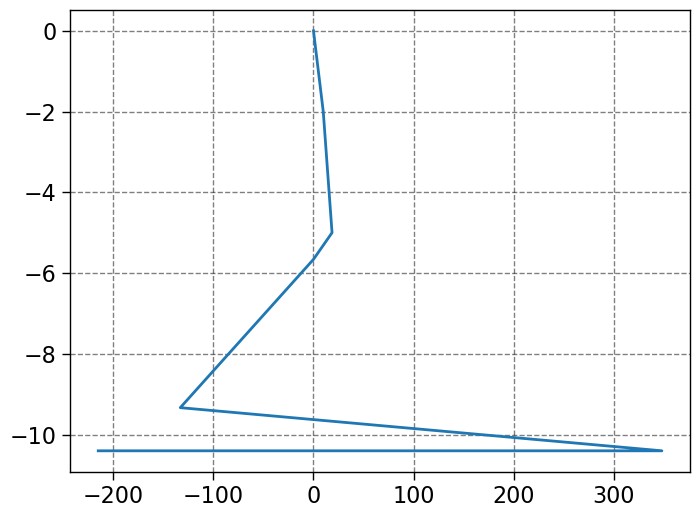

In [11]:
pressure_draw(properties)
